In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from matplotlib.colors import Normalize
import cv2

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

acT1_complex = np.load(r"C:\Users\Timothy\Desktop\数学建模相关\二轮\数据集\data_amplitude_T1_complex.npy")
df = pd.DataFrame(acT1_complex)

In [31]:
classified = []
classified_p = []
# for i in range(100, df.shape[0]):
# for i in range(430, 461):
# for i in range(600, 631):
for i in range (720, 751):
    # 一次去噪+特异性滤波

    # 生成Pxx, freqs, bins
    plt.figure(figsize=(10, 6))
    Pxx, freqs, bins, im = plt.specgram(df.iloc[i], NFFT=1024, Fs=1, noverlap=500, cmap='jet')
    plt.close()
    # 对Pxx应用高斯滤波
    Pxx_filtered = gaussian_filter(Pxx, sigma=0.1)
    # 保存原来的颜色映射
    vmin = np.min(10 * np.log10(Pxx_filtered))
    vmax = np.max(10 * np.log10(Pxx_filtered))
    norm = Normalize(vmin=vmin, vmax=vmax)
    # 特异性抑制
    index = np.where((freqs >= 0.03) & (freqs <= 0.2))
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))
    suppress_func = 1 - sigmoid(Pxx_filtered[index]/500000000) # 计算抑制函数
    Pxx_filtered[index] = Pxx_filtered[index] * suppress_func
    # 使用matplotlib绘制图像
    fig, ax = plt.subplots(figsize=(10, 6))
    cax = ax.pcolormesh(bins, freqs, 10 * np.log10(Pxx_filtered), cmap='jet', norm=norm)
    ax.set_title('频谱图')
    ax.set_xlabel('脉冲数')
    ax.set_ylabel('频率')
    ax.set_ylim(-0.3, 0.3)
    fig.colorbar(cax)
    plt.close()
    # 将matplotlib图像转换为OpenCV图像
    fig.canvas.draw()
    img = np.array(fig.canvas.renderer.buffer_rgba())
    img = cv2.cvtColor(img, cv2.COLOR_RGBA2BGR)


    # 轮廓提取（二值图）

    # 读取图像，并确定处理区域
    img = cv2.fastNlMeansDenoisingColored(img, None, 10, 10, 7, 21) # 二次去噪（OpenCV）
    roi = img[:, :700]
    # 提取红色区域
    hsv = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
    lower_red = np.array([0, 70, 50])
    upper_red = np.array([10, 255, 255])
    # 查找轮廓
    mask = cv2.inRange(hsv, lower_red, upper_red)
    res = cv2.bitwise_and(roi, roi, mask=mask)
    gray = cv2.cvtColor(res, cv2.COLOR_BGR2GRAY) # 将图像转换为灰度图
    _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY) # 应用阈值操作，将图像转换为二值
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


    # 分类

    # 将图像的像素值除以255，得到0和1的矩阵
    binary_matrix = gray / 255
    threshcls = 100
    print(f"{i}:", np.sum(binary_matrix))
    if (np.sum(binary_matrix) > threshcls):
        classified.append(1)
        # classified_p.append([i, np.sum(binary_matrix)])
    else:
        classified.append(0)
        # classified_p.append([i, np.sum(binary_matrix)])
    # 打印分类结果
print(classified)

720: 0.0
721: 0.0
722: 0.0
723: 0.0
724: 0.0
725: 0.0
726: 0.0
727: 0.0
728: 0.0
729: 0.0
730: 0.0
731: 0.0
732: 0.0
733: 1.003921568627451
734: 0.0
735: 0.0
736: 0.49019607843137253
737: 0.0
738: 0.0
739: 0.0
740: 0.0
741: 0.0
742: 0.0
743: 0.0
744: 0.0
745: 0.0
746: 0.0
747: 0.0
748: 0.0
749: 0.0
750: 0.0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


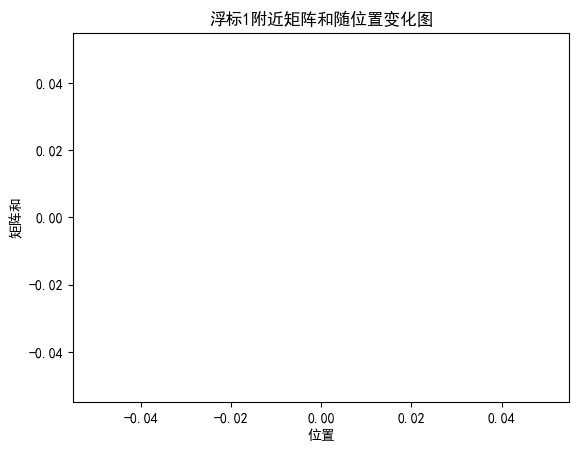

0


In [32]:

plt.plot([i[0] for i in classified_p], [i[1] for i in classified_p] , 'o-')

plt.plot([i[0] for i in classified_p], threshcls * np.ones(len(classified_p)), 'r--')
plt.xlabel('位置')
plt.ylabel('矩阵和')
plt.title('浮标1附近矩阵和随位置变化图')
plt.show()
print(len(classified_p))